In [1]:
# Import Python modules

import pandas as pd
import numpy as np
import rdkit
from numpy import mean
from numpy import std
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
import pickle
import tensorflow as tf

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import cross_val_score, cross_validate

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [2]:
# Load the dataset

df = pd.read_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\LTX_ChemAI_Challenge_Data-mordred.csv', low_memory=False)
#df.head()

In [3]:
# Remove duplicated molecules

df2 = df.drop_duplicates(subset=["SMILES"], keep=False)
#df2.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Df_clean.csv', sep = ',', index=False)


In [4]:
# Check errors in the descriptor values and perform kNN imputation

features = df2.iloc[:, 2:]
rest_df = df2[['Toxicity Classification','SMILES']]

df_nan = features.replace(to_replace = r'[a-zA-Z]', value = np.nan, regex = True).replace(np.inf, np.nan)

to_cast = list(df_nan.select_dtypes(include=[object]).columns)
df_nan[to_cast] = df_nan[to_cast].astype(dtype=np.float64)

df_nan[df_nan <= -1e38] = np.nan
df_nan[df_nan >= 1e38] = np.nan

out_columns = list(features.columns)

nan_limit=0.15
all_nan=df_nan.columns[df_nan.isna().sum()>len(df_nan.isna())*nan_limit].tolist()

if len(all_nan)>0: 
    print('Warning!', len(all_nan), 'descriptors have too many NaN values and have been removed:', all_nan)
    print('The limit is marked to the', nan_limit*100, '%') 
for i in all_nan: 
    out_columns.remove(i) 
   
df_nan = df_nan[out_columns]
df_nan = df_nan.dropna(axis=1, how='all')

imputer = KNNImputer(missing_values=np.nan, n_neighbors=3, weights="uniform")

result0 = imputer.fit(df_nan)

result = imputer.transform(df_nan)
imputed_df = pd.DataFrame(result, columns = out_columns)

rest_df.reset_index(drop=True, inplace=True)
imputed_df.reset_index(drop=True, inplace=True)
df3 = pd.concat([rest_df,imputed_df], axis = 1)

#df3.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Df_imputed.csv', sep = ',', index=False)


Warning! 188 descriptors have too many NaN values and have been removed: ['SpAbs_Dt', 'SpMax_Dt', 'SpDiam_Dt', 'SpAD_Dt', 'SpMAD_Dt', 'LogEE_Dt', 'SM1_Dt', 'VE1_Dt', 'VE2_Dt', 'VE3_Dt', 'VR1_Dt', 'VR2_Dt', 'VR3_Dt', 'DetourIndex', 'MAXsLi', 'MAXssBe', 'MAXssssBe', 'MAXssBH', 'MAXsssB', 'MAXssssB', 'MAXsCH3', 'MAXdCH2', 'MAXssCH2', 'MAXtCH', 'MAXdsCH', 'MAXaaCH', 'MAXsssCH', 'MAXddC', 'MAXtsC', 'MAXdssC', 'MAXaasC', 'MAXaaaC', 'MAXssssC', 'MAXsNH3', 'MAXsNH2', 'MAXssNH2', 'MAXdNH', 'MAXssNH', 'MAXaaNH', 'MAXtN', 'MAXsssNH', 'MAXdsN', 'MAXaaN', 'MAXsssN', 'MAXddsN', 'MAXaasN', 'MAXssssN', 'MAXsOH', 'MAXdO', 'MAXssO', 'MAXaaO', 'MAXsF', 'MAXsSiH3', 'MAXssSiH2', 'MAXsssSiH', 'MAXssssSi', 'MAXsPH2', 'MAXssPH', 'MAXsssP', 'MAXdsssP', 'MAXsssssP', 'MAXsSH', 'MAXdS', 'MAXssS', 'MAXaaS', 'MAXdssS', 'MAXddssS', 'MAXsCl', 'MAXsGeH3', 'MAXssGeH2', 'MAXsssGeH', 'MAXssssGe', 'MAXsAsH2', 'MAXssAsH', 'MAXsssAs', 'MAXsssdAs', 'MAXsssssAs', 'MAXsSeH', 'MAXdSe', 'MAXssSe', 'MAXaaSe', 'MAXdssSe', 'MAXddss

In [5]:
# Initial feature reduction. Correlated values: I need to find which descriptors are collinear based on a correlation coefficient between features of 0.9. 
# For each pair of correlated features, only one of the pair is set for removal.

features2 = df3.iloc[:, 2:]

correl_threshold = 0.9

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset
    
features2 = correlation(features2, correl_threshold)

rest_df.reset_index(drop=True, inplace=True)
features2.reset_index(drop=True, inplace=True)
df4 = pd.concat([rest_df,features2], axis = 1)

#df4.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Df_initial_reduction.csv', sep = ',', index=False)



In [6]:
# Feature Scaling: some Machine Learning algorithms are very sensitive to feature scaling They can be extremely influenced by features that vary in larger amounts than others. 
# That's why feature scaling is an important step in the process of building a machine learning model. Standardization transforms the data to have zero mean and a variance of 1.

features3 = df4.iloc[:, 2:]

scaler = StandardScaler()
scaled_descr = scaler.fit_transform(features3)

df_scaled_descr = pd.DataFrame(scaled_descr, columns = list(features3.columns))

rest_df.reset_index(drop=True, inplace=True)
df_scaled_descr.reset_index(drop=True, inplace=True)
df5 = pd.concat([rest_df,df_scaled_descr], axis = 1)

#df5.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Df_scaled.csv', sep = ',', index=False)

In [7]:
# Training and test set splitting. The simplest way is to split the data randomly (using a seed). I will stablish a proportion of 70% of data for training and 30% for the test set, respectively.

SEED = 300
test_size = 0.3

df_train, df_test = train_test_split(df5, test_size=test_size, random_state=SEED)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)


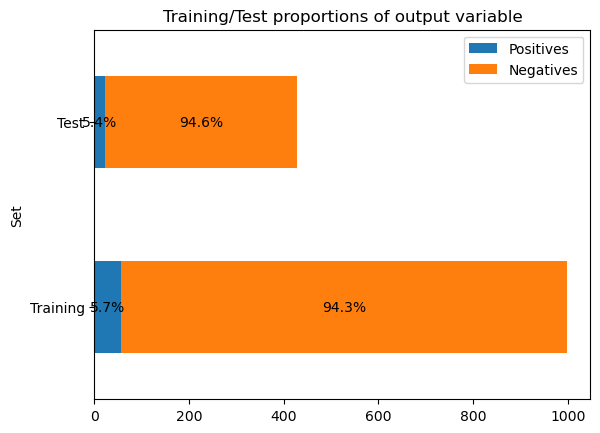

In [8]:
# Check the proportions of positive and negative values in the training and test sets.

%matplotlib inline

dic = {"Training": df_train['Toxicity Classification'].value_counts(ascending=True), 
       "Test": df_test['Toxicity Classification'].value_counts(ascending=True)}

df_proports = pd.DataFrame.from_dict(dic, orient='index')
df_proports.reset_index(inplace=True)
df_proports.rename(columns={"index":"Set", 1:"Positives", 0:"Negatives"},inplace=True)

df_proports.plot(
    x="Set",
    kind = "barh",
    stacked = True,
    title = "Training/Test proportions of output variable",
    mark_right = True)

df_total = df_proports["Positives"] + df_proports["Negatives"]  
df_rel = df_proports[df_proports.columns[1:]].div(df_total,0)*100

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df_proports.iloc[:, 1:].cumsum(1)[n], df_proports[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', va = 'center', ha = 'center')

In [9]:
# Save training and test sets.

df_train.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Training_set.csv', sep = ',', index=False)
df_test.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Test_set.csv', sep = ',', index=False)

In [10]:
# Feature Selection. Once I have cleaned and splitted our dataset into training and test sets, I can proceed to select the most meaningful features to build a model that will predict our output variable. 

# I will start with a method called Recursive Feature Elimination (RFE). RFE is a method that can use different estimators as a base to order and select features. These estimators are in 
# themselves supervised learning methods, that will provide information about feature importance.

# Selecting features with RFE and Logistic Regression estimator.

#Read the training set and separate the descriptors array and the output variable

X = df_train.iloc[:,2:]
y = df_train["Toxicity Classification"]

estimator = LogisticRegression(max_iter=300)

#I need to stablish the number of features to select.
num_features = 25
#Instantiate the RFE selector
selector = RFE(estimator, n_features_to_select=num_features, step=1)
#Fit the RFE selector to the training data
selector = selector.fit(X,y)

#Subset the descriptors dataset 
feats_train_rfe1 = X.loc[:, selector.support_]
#Join the selected descriptors to the output variable and SMILES column
df_train_rfe1 = pd.concat([y, df_train.SMILES, feats_train_rfe1], axis=1)

#Read the test set and select only descriptor columns of interest

descr_test = df_test.loc[:,list(feats_train_rfe1.columns)]
df_test_rfe1 = pd.concat([df_test.loc[:,["Toxicity Classification", "SMILES"]], descr_test], axis=1)

#Save both datasets as csv files
df_train_rfe1.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Training_RFE_logreg.csv', sep = ',', index=False)
df_test_rfe1.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Test_RFE_logreg.csv', sep = ',', index=False)

print("The features selected are:")
for feat in list(feats_train_rfe1.columns):
    print("\n",feat)



The features selected are:

 nBase

 ATSC2c

 ATSC3c

 AATSC0c

 AATSC7dv

 MATS1c

 MATS2c

 GATS1c

 GATS7s

 GATS3p

 BCUTc-1h

 BCUTs-1h

 NsCH3

 NssssC

 NssNH2

 NssNH

 NsssNH

 IC2

 FilterItLogS

 AMID_O

 piPC8

 n5ARing

 n5AHRing

 SLogP

 JGI2


In [11]:
# Selecting features with RFE and Decision Tree estimator.

#Read the train set and separate the descriptors array and the output variable

X = df_train.iloc[:,2:]
y = df_train[("Toxicity Classification")]

estimator = DecisionTreeClassifier()

#I need to stablish the number of features to select.
num_features = 25
#Instantiate the RFE selector
selector = RFE(estimator, n_features_to_select=num_features, step=1)
#Fit the RFE selector to the training data
selector = selector.fit(X,y)

#Subset the descriptors dataset 
feats_train_rfe2 = X.loc[:, selector.support_]
#Join the selected descriptors to the output variable and SMILES column
df_train_rfe2 = pd.concat([y, df_train.SMILES, feats_train_rfe2], axis=1)

#Read the test set and select only descriptor columns of interest

descr_test = df_test.loc[:,list(feats_train_rfe2.columns)]
df_test_rfe2 = pd.concat([df_test.loc[:,["Toxicity Classification", "SMILES"]], descr_test], axis=1)

#Save both datasets as csv files
df_train_rfe2.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Training_RFE_dectree.csv', sep = ',', index=False)
df_test_rfe2.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Test_RFE_dectree.csv', sep = ',', index=False)

print("The features selected are:")
for feat in list(feats_train_rfe2.columns):
    print("\n",feat)


The features selected are:

 SpMax_A

 nAromAtom

 AATS5s

 AATS6i

 ATSC3c

 ATSC3d

 ATSC1se

 ATSC2se

 ATSC0p

 AATSC1d

 AATSC4d

 AATSC0Z

 AATSC7i

 MATS2c

 GATS1s

 GATS3s

 AXp-4dv

 NssNH

 fragCpx

 BIC4

 PEOE_VSA3

 EState_VSA9

 VSA_EState6

 SLogP

 JGI3


In [12]:
# Feature Selection. Permutation Importance is also based on a supervised learning algorithm that takes the role of estimator to determine the importance of each feature.
# Use of the Logistic Regression as estimator.

#Read the train set and separate the descriptors array and the output variable

X = df_train.iloc[:,2:]
y = df_train[("Toxicity Classification")]

estimator = LogisticRegression(max_iter=200)

estimator.fit(X, y)
perm = PermutationImportance(estimator).fit(X, y)

#I use the attribute perm.feature_importances_ for feature selection 
#let's e.g. select features which increase accuracy by at least 0.01:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)

#Get the features and importances in a dataframe and sort them to see which ones are most important
importances_ = list(perm.feature_importances_)
features__permutation = list(X.columns)

dataframe_permutation = pd.DataFrame({'feature' : features__permutation,
                            'importance' : importances_},
                            columns=['feature','importance'])

dataframe_permutation_ordered = dataframe_permutation.sort_values('importance',ascending=False)

print(dataframe_permutation_ordered)



        feature  importance
433      NsssNH    0.020441
430       NssNH    0.011222
238      MATS2c    0.009619
18           nP    0.009218
435        NaaN    0.006212
..          ...         ...
719        JGI4   -0.000401
715    RotRatio   -0.000601
113      ATSC5d   -0.000601
116      ATSC8d   -0.000601
687  nG12FHRing   -0.000802

[730 rows x 2 columns]


In [13]:
#Insert the number of features to select here
pi_n_feats = 20

#Subset the descriptors dataset 
feat_select_pi = list(dataframe_permutation_ordered.iloc[:pi_n_feats,0])
feats_train_pi1 = X.loc[:,feat_select_pi]

#Join the selected descriptors to the output variable and SMILES column
df_train_pi1 = pd.concat([y, df_train.SMILES, feats_train_pi1], axis=1)

#Read the test set and select only descriptor columns of interest

descr_test = df_test.loc[:,list(feats_train_pi1.columns)]
df_test_pi1 = pd.concat([df_test.loc[:,["Toxicity Classification", "SMILES"]], descr_test], axis=1)

#Save both datasets as csv files
df_train_pi1.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Training_PI_logreg.csv', sep = ',', index=False)
df_test_pi1.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Test_PI_logreg.csv', sep = ',', index=False)

print("The features selected are:")
for feat in list(feats_train_pi1.columns):
    print("\n",feat)

The features selected are:

 NsssNH

 NssNH

 MATS2c

 nP

 NaaN

 NssNH2

 NsssN

 ATSC3c

 n3HRing

 C4SP3

 n5AHRing

 BCUTc-1l

 PEOE_VSA12

 JGI2

 BCUTc-1h

 AATSC0c

 SLogP

 n9FAHRing

 ATSC8v

 PEOE_VSA9


In [14]:
# Feature Selection. Permutation Importance is also based on a supervised learning algorithm that takes the role of estimator to determine the importance of each feature.
# Use of the Decision Tree as estimator.

#Read the train set and separate the descriptors array and the output variable

X = df_train.iloc[:,2:]
y = df_train[("Toxicity Classification")]

estimator = DecisionTreeClassifier()

estimator.fit(X, y)
perm = PermutationImportance(estimator).fit(X, y)

#I use the attribute perm.feature_importances_ for feature selection 
#let's e.g. select features which increase accuracy by at least 0.01:
sel = SelectFromModel(perm, threshold=0.01, prefit=True)

#Get the features and importances in a dataframe and sort them to see which ones are most important
importances_ = list(perm.feature_importances_)
features__permutation = list(X.columns)

dataframe_permutation = pd.DataFrame({'feature' : features__permutation,
                            'importance' : importances_},
                            columns=['feature','importance'])

dataframe_permutation_ordered = dataframe_permutation.sort_values('importance',ascending=False)

print(dataframe_permutation_ordered)


       feature  importance
716      SLogP    0.072144
430      NssNH    0.041884
568  PEOE_VSA3    0.034870
405    AXp-4dv    0.021643
3      SpMax_A    0.017234
..         ...         ...
252     MATS8s    0.000000
253     MATS1Z    0.000000
254     MATS2Z    0.000000
255     MATS3Z    0.000000
729      WPath    0.000000

[730 rows x 2 columns]


In [15]:
#Insert the number of features to select here
pi_n_feats = 20

#Subset the descriptors dataset 
feat_select_pi = list(dataframe_permutation_ordered.iloc[:pi_n_feats,0])
feats_train_pi1 = X.loc[:,feat_select_pi]

#Join the selected descriptors to the output variable and SMILES column
df_train_pi1 = pd.concat([y, df_train.SMILES, feats_train_pi1], axis=1)

#Read the test set and select only descriptor columns of interest

descr_test = df_test.loc[:,list(feats_train_pi1.columns)]
df_test_pi1 = pd.concat([df_test.loc[:,["Toxicity Classification", "SMILES"]], descr_test], axis=1)

#Save both datasets as csv files
df_train_pi1.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Training_PI_dectree.csv', sep = ',', index=False)
df_test_pi1.to_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Test_PI_dectree.csv', sep = ',', index=False)

print("The features selected are:")
for feat in list(feats_train_pi1.columns):
    print("\n",feat)

The features selected are:

 SLogP

 NssNH

 PEOE_VSA3

 AXp-4dv

 SpMax_A

 ATSC0p

 SM1_Dzm

 GATS3s

 ATSC3c

 AATSC7i

 BalabanJ

 ATS7Z

 JGI3

 EState_VSA9

 ATSC3d

 AATSC2v

 GATS8dv

 ATSC5s

 AATSC4d

 ATSC4c


In [16]:
# Model generation: I will use the the trainingn data set to build the machine learning model, and the test set to validate the model.

# Step 1. Get the data.

train_dataset = pd.read_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Training_RFE_logreg.csv')

X_train = train_dataset.iloc[:, 2:]
Y_train = train_dataset["Toxicity Classification"]

#train_dataset.head()

# Step 2. Instantiate the stimator: select an algorithm and assign it to an object called model

#model = DecisionTreeClassifier()
model = LogisticRegression()

# Step 3. Fit the stimator.

model.fit(X_train,Y_train)

# Step 4: Assess the quality of the fit

Y_train_pred = model.predict(X_train)

# In the case of a classification method, the quality of a method is based in the confusion matrix (or error matrix). 
# The confusion matrix is a table where each row corresponds to the experimental value and each column to the predicted value.
# Calculation of the False Positives (FP), False Negatives (FN), True Positives (TP) and True Negatives (TN) from Y_train and Y_train_pred.

def classifier_assessment(Y_train, Y_train_pred):
    
    #WRITE YOUR CODE HERE
    data_length = len(Y_train)

    FP=0
    FN=0
    TP=0
    TN=0

    for i in range(data_length):
        if Y_train[i] == 0 and Y_train_pred[i] == 0:
            TN=TN+1
        elif Y_train[i] == 1 and Y_train_pred[i] == 0:
            FN=FN+1
        elif Y_train[i] == 1 and Y_train_pred[i] == 1:
            TP=TP+1
        elif Y_train[i] == 0 and Y_train_pred[i] == 1:
            FP=FP+1

    # Keep this print to chek your values
    print(TP,TN,FP,FN)

    print('\t\tPositive\tNegative')
    print('\tPositive\t'+str(TP)+'\t'+str(FN))
    print('\tNegative\t'+str(FP)+'\t'+str(TN))
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    
    # Keep this print to chek your values
    print('Accuracy:',accuracy)
    print('Sensitivity:',sensitivity)
    print('Specificity:',specificity)
    print('Precision:',precision)
    
    return [accuracy,sensitivity,specificity,precision]

train_metric_values = classifier_assessment(Y_train,Y_train_pred)

21 937 4 36
		Positive	Negative
	Positive	21	36
	Negative	4	937
Accuracy: 0.9599198396793587
Sensitivity: 0.3684210526315789
Specificity: 0.9957492029755579
Precision: 0.84


In [17]:
# Step 5: Validation of the model. Prediction of the values for the test set and evaluation of the model.

test_dataset = pd.read_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Test_RFE_logreg.csv')

X_test = test_dataset.iloc[:, 2:]
Y_test = test_dataset["Toxicity Classification"]

Y_test_pred = model.predict(X_test)

test_metric_values = classifier_assessment(Y_test,Y_test_pred)

2 402 3 21
		Positive	Negative
	Positive	2	21
	Negative	3	402
Accuracy: 0.9439252336448598
Sensitivity: 0.08695652173913043
Specificity: 0.9925925925925926
Precision: 0.4


In [18]:
# Modification of hyperparameters. The algorithms used to train the model can be tuned by adjusting some parameters that describe how the training is done. 
# Those are often called hyperparameters to differenciate of the parameters of the method that change during the training. 
# Which hyperparameters can be modified depends strongly on the nature of the algorithm. In the case of the Linear Regression, there are few parameters to be fitted.

# As it has been checked before, the dataset is very unbalanced. There are much more compounds with 0 than 1 values for Toxicity Classification. 
# Therefore, class_weight should be one of the hyperparameters to tweak to improve the model. 

model = LogisticRegression(fit_intercept = False, C = 0.05, class_weight = {0:1,1:6}, penalty = "none")

model.fit(X_train,Y_train)

Y_train_pred = model.predict(X_train)
train_metric_values = classifier_assessment(Y_train,Y_train_pred)

Y_test_pred = model.predict(X_test)
test_metric_values = classifier_assessment(Y_test,Y_test_pred)


57 477 464 0
		Positive	Negative
	Positive	57	0
	Negative	464	477
Accuracy: 0.5350701402805611
Sensitivity: 1.0
Specificity: 0.5069075451647184
Precision: 0.10940499040307101
21 196 209 2
		Positive	Negative
	Positive	21	2
	Negative	209	196
Accuracy: 0.5070093457943925
Sensitivity: 0.9130434782608695
Specificity: 0.4839506172839506
Precision: 0.09130434782608696


c:\Users\proto\anaconda3\envs\Protocosas\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [19]:
# Perform Cross Validation prediction and score

together = pd.concat([train_dataset,test_dataset])

X_together = together.iloc[:, 2:]
y_together = together['Toxicity Classification']

model = LogisticRegression(fit_intercept = False, C = 0.05, class_weight = {0:1,1:6}, penalty = "none")

scores_together = cross_val_score(model, X_together, y_together, cv=10, scoring='accuracy', n_jobs = -1)

for scores in scores_together:
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


Accuracy: 0.476 (0.000)
Accuracy: 0.531 (0.000)
Accuracy: 0.490 (0.000)
Accuracy: 0.427 (0.000)
Accuracy: 0.580 (0.000)
Accuracy: 0.552 (0.000)
Accuracy: 0.556 (0.000)
Accuracy: 0.585 (0.000)
Accuracy: 0.493 (0.000)
Accuracy: 0.479 (0.000)


CONCLUSIONS of the ML models:
The original dataset is unbalanced (1476 compounds: 1366 with a value of 0 and 110 with value of 1), making the building of the model difficult for the prediction of positive values.
From the feature selection process, the most relevant descriptors and properties have been found. Among them, nacid (number of acidic centres) and SLogP (representation of the lipophilicity of the molecules) seem to be important for the model. 

Further steps: 
In order to use the model, a function to predict toxicity values and determine the applicability domain of the predictions should be built.
A way to address the unbalanced dataset, undersampling could be performed. I think tweaking the hyperparameters of the models should be done first to improve the model.

In [20]:
# Building a neural network classification model using TensorFlow

dataset = pd.read_csv(r'C:\Users\proto\Desktop\Pablo\PAS\Ladder Tx\Df_scaled.csv', low_memory=False)

X = dataset.iloc[:, 2:]
y = dataset['Toxicity Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

history = model.fit(X_train, y_train, epochs=30)


Epoch 1/30
32/32 [==============================] - 1s 2ms/step - loss: 1.2371 - accuracy: 0.9038 - precision: 0.0250 - recall: 0.0172    
Epoch 2/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.9369 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/30
32/32 [==============================] - 0s 2ms/step - loss: 0.2693 - accuracy: 0.9419 - precision: 0.5000 - recall: 0.0345   
Epoch 4/30
32/32 [==============================] - 0s 3ms/step - loss: 0.1982 - accuracy: 0.9419 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/30
32/32 [==============================] - 0s 3ms/step - loss: 0.1634 - accuracy: 0.9409 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/30
32/32 [==============================] - 0s 3ms/step - loss: 0.1257 - accuracy: 0.9419 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/30
32/32 [==============================] - 0s 3ms/step - loss: 0.0967 - accuracy: 0.9429 - precision: 1.0000 - recall: 0.0172   
Epoch 8/30
32

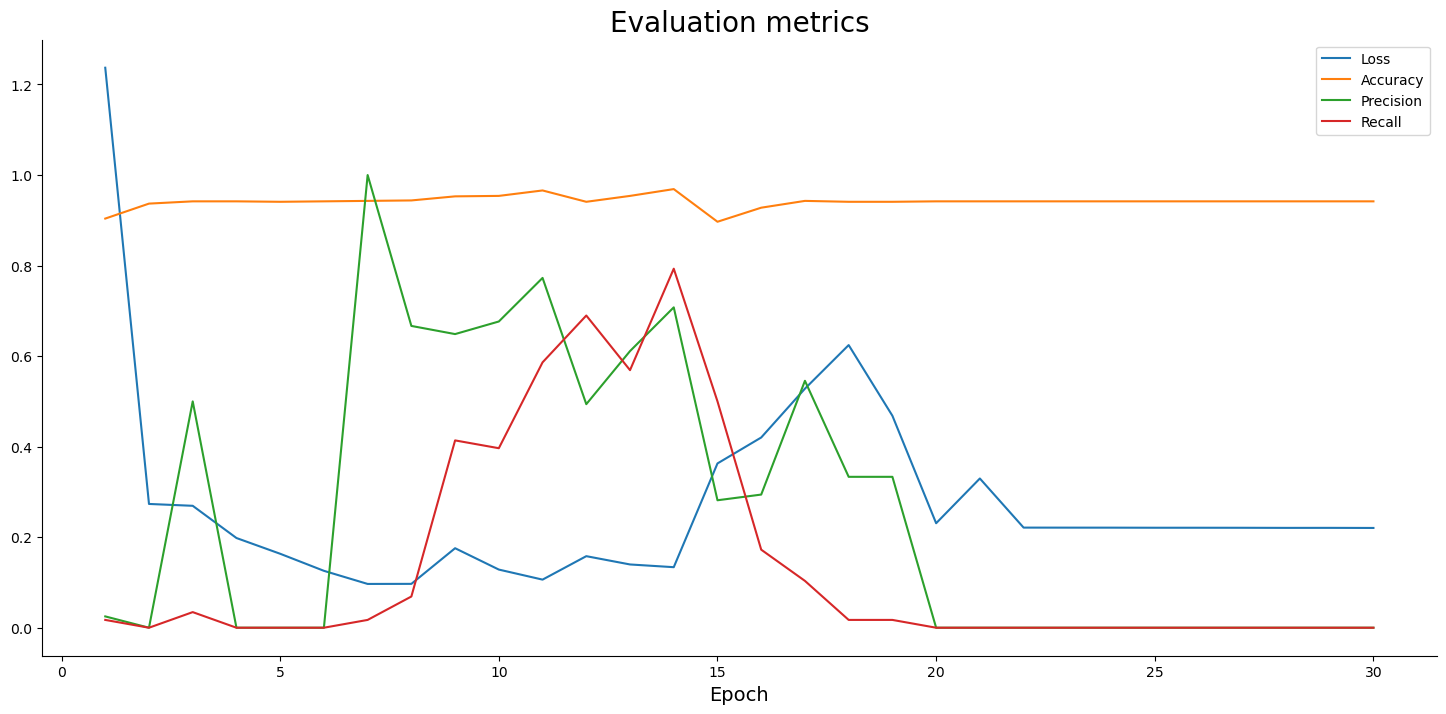

In [21]:
# Building a neural network classification model using TensorFlow
# Visualizing model performance

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

plt.plot(np.arange(1, 31), history.history['loss'], label='Loss')
plt.plot(np.arange(1, 31), history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(1, 31), history.history['precision'], label='Precision')
plt.plot(np.arange(1, 31), history.history['recall'], label='Recall')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();


In [22]:
# Building a neural network classification model using TensorFlow
# Making predictions

predictions = model.predict(X_test)

prediction_classes = [1 if prob > 0.5 else 0 for prob in np.ravel(predictions)]

print(confusion_matrix(y_test, prediction_classes))

print(f'Accuracy: {accuracy_score(y_test, prediction_classes):.2f}')
print(f'Precision: {precision_score(y_test, prediction_classes):.2f}')
print(f'Recall: {recall_score(y_test, prediction_classes):.2f}')



14/14 [==============================] - 0s 1ms/step
[[406   0]
 [ 22   0]]
Accuracy: 0.95
Precision: 0.00
Recall: 0.00


c:\Users\proto\anaconda3\envs\Protocosas\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results: the model is not useful, as a precision of 0.00 is obtained. The unbalanced dataset (~96% of 0 and ~4 of 1 values) makes difficult the prediction of positive values. 
